# Rectificación
## Determinación del Nº de pisos teóricos mediante el método de McCabe-Thiele
### Ha de proyectarse una columna de rectificación para un caudal A (kg/h) de una mezcla de dos compuestos, a y b, siendo wa la fracción máscia del componente a la alimentación. Se desea recuperar un destilado con un contenido wd del compuesto a, y un residuo con un contenido wr de a; todos los porcentajes son en masa. 

<img src="./Imagenes/Esquema_Columna.jpg" height="300" width="300"\>

### Determinar el número de pisos de equilibrio necesarios para llevar a cabo la separación, así como el número de pisos de equilibrios mínimos con los que se podría realizar la misma.

In [1]:

#%matplotlib notebook

%matplotlib inline
import seaborn
import numpy as np
import matplotlib.pyplot as mpl
from scipy import optimize
import random
import math
import pandas as pd
import IPython.core.display as di
pd.set_option('display.notebook_repr_html', True)
import notebook
from IPython.display import clear_output, display, HTML, Image,Math, Latex
from IPython.external import mathjax
FigureSize=(10,10) # Para matplotlib inline
#FigureSize=(10.5,4.5) # Para matplotlib notebook


def equilib(x,y,alfa):
    f=y-alfa*x/(1+(alfa-1)*x)
    return f

def InterseccionRalimentoCurvaEquilibrio(x,q,xa,alfa):
    value=(alfa*x/(1+(alfa-1)*x))- RectaAlimentacion(x,q,xa)
    return value
    
    
def RectaAlimentacion(x,q,xa):
    y=-q/(1-q)*x+xa/(1-q)
    return y

def RazonReflujoMinima(q,xa,alfa,xd_a):
    # Cálculo de la razón de reflujo mínima para alcanzar los requisitos
    if (q!=1 and q!=0):
        x_AlEq=optimize.fsolve(InterseccionRalimentoCurvaEquilibrio,\
                               [0.5],args=(q,xa,alfa)) 
        x_AlEq=round(float(x_AlEq),3)
        y_AlEq=RectaAlimentacion(x_AlEq,q,xa)
        y_AlEq=round(float(y_AlEq),3)
    elif q==0:
        y_AlEq=xa
        y_AlEq=round(float(y_AlEq),3)
        x_AlEq=optimize.fsolve(equilib,[0.5],args=(y_AlEq,alfa))
        x_AlEq=round(float(x_AlEq),3)
    elif q==1:
        x_AlEq=xa
        x_AlEq=round(float(x_AlEq),3)
        y_AlEq=alfa*x_AlEq/(1+(alfa-1)*x_AlEq)
        y_AlEq=round(float(y_AlEq),3)
        
    AR=(xd_a-y_AlEq)/(xd_a-x_AlEq)
    RazonMinima=AR/(1-AR)
    
    return RazonMinima
    

def RectaOperativaEnriquecimiento(x,Ln,D,xd):
    y=Ln/(Ln+D)*x+(D*xd)/(Ln+D)
    return y


def RectaOperativaAgotamiento(x,Ln,D,xd,xa,A,q):
    y=((Ln+q*A)/(Ln+D-(1-q)*A))*x+(D*xd-A*xa)/(Ln+D-(1-q)*A)
    return y
    

def InterseccionRO(x,Ln,D,xd,xa,A,q):
    value=RectaOperativaEnriquecimiento(x,Ln,D,xd)-\
           RectaOperativaAgotamiento(x,Ln,D,xd,xa,A,q)
    return value

def Balances_Materia(incognitas,A,xa,xd,xr):
    D,R=incognitas
    
    values=[D+R-A]
    values.append(D*xd+R*xr-A*xa)
    
    return values
    

def generador_valores():  # generación de PM de los compuestos

    PM_c1=random.randint(50.,100.)
    PM_c2=random.randint(50.,100.)
    A=round((random.randint(10000,20000)/24))
    q_azar=random.uniform(-2,2)
    q=round(random.choice([0,1,q_azar]),2)
    wa=round(random.random(),3)
    wd=round(random.uniform(0.75,0.95),3)
    wr=round(random.uniform(0.02,0.15),3)
    alfa = round(random.uniform(1.5,3.5),2)
    
    return PM_c1, PM_c2,A,q,wa, wd,wr,alfa

def composicionesMolaresyCaudal(caudalMasico,wa,PM_c1,PM_c2):
    
    caudalMolar=round(((caudalMasico*wa)/PM_c1+(caudalMasico*(1-wa))/PM_c2),3)
    xa=round(((caudalMasico*wa)/PM_c1/caudalMolar),3)
    xb=round((1-xa),3)
    
    return caudalMolar,xa,xb
    
def composicionesMolares(wa,PM_c1,PM_c2):

    xa=round(((wa/PM_c1)/(wa/PM_c1+(1-wa)/PM_c2)),3)
    xb=round((1-xa),3)
    
    return xa,xb


# q Fracción de vapor en la alimentación
# PM_c1, PM_c2 Pesos moleculares de los compuestos
# A Caudal másico alimentación (kg/día)
# wd Fracción  másica del componente ligero en  el destilado
# wr Fracción  másica del componente ligero en la corriente residuo
# wa Fracción  másica del componente ligero en la alimentación
# R Razón de recirculación
# Alfa es la volatilidad relativa

while True:
    PM_c1, PM_c2,A,q,wa, wd,wr, alfa=generador_valores()

    caudalMolarA,xa,xb=composicionesMolaresyCaudal(A,wa,PM_c1,PM_c2)               
    xd_a,xd_b=composicionesMolares(wd,PM_c1,PM_c2)
    xr_a,xr_b=composicionesMolares(wr,PM_c1,PM_c2)

    D,R=optimize.fsolve(Balances_Materia,[5,5],args=(caudalMolarA,xa,xd_a,xr_a))
    D=round(float(D),3)
    R=round(float(R),3)
    if (D>0 and R>0):
        break
        
    
# Fracción de vapor en la alimentación
# q = 1
# PM_c1,PM_c2=78,92
# A=15000/(24)
# wd = 0.97 # Fracción  másica del componente ligero en  el destilado
# wr = 0.02 # Fracción  másica del componente ligero en la corriente residuo
# wa = 0.4  # Fracción  másica del componente ligero en la alimentación
# alfa = 2.45
# RazonReflujo = 1.5







RazonMinima=RazonReflujoMinima(q,xa,alfa,xd_a)
# Razón de reflujo de la columna
while True:
    RazonReflujo=round(random.gauss(6, 3.5),1)
    if RazonReflujo>=1.1*RazonMinima:
        break

variablesConocidasNombres=['A (kg/h)',' Wa ',' Wd ',' wr ','Razón de Reflujo',' q ', 'Volatilidad relativa',\
                          'Peso molecular a (g/mol)','Peso molecular b (g/mol)']
ValoresMostrados=[A,wa, wd,wr,RazonReflujo, q,alfa,PM_c1, PM_c2]

# Determinación de los puntos de la curva de equilibro
ye=[]
xe=[]
for i in range(21):
    y = round(0.05 * i,3)
    ye.append(y)
    xe_i=optimize.fsolve(equilib,[0.5],args=(y,alfa)) 
    xe.append(round(float(xe_i[0]),3))
    
    

display(HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Mostrar código')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Esconder código')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Mostrar código"></form>'''))




#display(Image(filename='./Imagenes/Esquema_Columna.jpg', width=350));

display(HTML('<h1 style="color:#000000"><strong>Los datos del problema son:</strong></h1>'))

data = dict(zip(variablesConocidasNombres, ValoresMostrados))
values = pd.DataFrame(data,index=['Datos'], columns=variablesConocidasNombres)
display(values)


display(HTML('<p style="color:000000"><strong>Curva de equilibrio</strong>: la curva de equilibrio de la mezcla\
             viene dada por la volatilidad relativa de ambos compuestos mediante la siguiente expresión:</p>'))
display(Math(r'y=\frac{ \alpha \cdot x}{1+x\cdot \left( \alpha -1 \right)}'))


A (kg/h)    Wa     Wd     wr   Razón de Reflujo    q   \
Datos       500  0.447  0.797  0.031              12.7 -1.76   

       Volatilidad relativa  Peso molecular a (g/mol)  \
Datos                  2.26                        88   

       Peso molecular b (g/mol)  
Datos                        76

<IPython.core.display.Math object>

In [2]:
display(HTML('<h1 style="color:#000000"><strong>En primer lugar se dibuja la curva de equilibrio:</strong></h1>'))

mpl.plot(xe,ye, 'g-',label = 'Curva equilibrio')
mpl.plot(ye,ye, 'k-')
mpl.xlabel('Fracción molar en el líquido (xe)')
mpl.ylabel('Fracción molar en el vapor (ye)')

mpl.grid(b=True, which='both', color='0.65',linestyle='-')
mpl.xlim(0,1)
mpl.ylim(0,1)

    
mpl.legend(loc = 'best')
mpl.show()

display(HTML('<h3  style="color:#000000"><strong>Y se determinan los caudales molares de alimento, \
    destilado y residuo, así como las composiciones molares del compuesto ligero\
    en cada una de estas corrientes:</strong></h3>'))

CaudalesComposicionesMolaresNombres=['A (kmol/h)','D (kmol/h)','R (kmol/h)', ' xa ',' xd ',' xr ']
CaudalesComposicionesMolaresValores=[caudalMolarA,D,R,xa,xd_a,xr_a]

data1 = dict(zip(CaudalesComposicionesMolaresNombres, CaudalesComposicionesMolaresValores))
values1 = pd.DataFrame(data1,index=['Datos'], columns=CaudalesComposicionesMolaresNombres)
display(values1)




A (kmol/h)  D (kmol/h)  R (kmol/h)    xa     xd     xr 
Datos       6.178       3.184       2.994  0.411  0.772  0.027

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Ln   Pendiente (ROE)  Ordenada (ROE)  Pendiente (ROA)  \
Valores  40.437            0.927           0.056            0.628   

         Ordenada (ROA)  
Valores           0.152

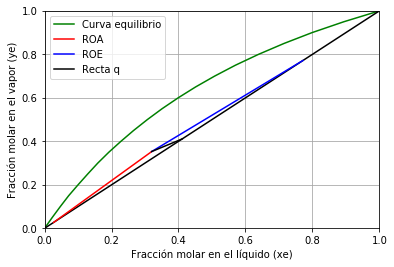

In [3]:
display(HTML('<h1 style="color:#000000"><strong>Se calcula el valor de las pendientes y ordenadas \
en el origen correspondientes a las rectas operativas de enriquecimiento (ROE) y agotamiento (ROA).</strong></h1>'))


Ln=round(RazonReflujo*D,3)
PendienteROE=round((Ln/(Ln+D)),3)
OrdenadaROE=round(((D*xd_a)/(Ln+D)),3)
PendienteROA=round(((Ln+q*A)/(Ln+D-(1-q)*A)),3)
OrdenadaROA=round(((D*xd_a-A*xa)/(Ln+D-(1-q)*A)),3)

display(Math(r'Pendiente=\text{Razon de Reflujo}\cdot D'))

display(HTML('<h3 style="color:#000000"><strong>Recta operativa de enriquecimiento (ROE):</strong></h3>'))
display(Math(r'Pendiente=\frac{ L_{n}}{L_{n}+D}'))
display(Math(r'\text{Ordenada en el origen}=\frac{ D \cdot x_{d} }{L_{n}+D}'))
             
display(HTML('<h3  style="color:#000000"><strong>Recta operativa de agotamiento (ROA):</strong></h3>'))
display(Math(r'Pendiente=\frac{  L_{n}+q \cdot A }{L_{n}+D-\left(1-q\right) \cdot A }'))
display(Math(r'\text{Ordenada en el origen}=\frac{  D\cdot x_d - A\cdot x_a}{L_{n}+D-\left(1-q\right) \cdot A }'))


RectasNombres=[' Ln ','Pendiente (ROE)','Ordenada (ROE)','Pendiente (ROA)','Ordenada (ROA)']
RectasValores=[Ln,PendienteROE,OrdenadaROE,PendienteROA,OrdenadaROA]

data2 = dict(zip(RectasNombres, RectasValores))
values2 = pd.DataFrame(data2,index=['Valores'], columns=RectasNombres)
#values2.set_index('tiempo (min)',inplace=True)
display(values2)

display(HTML('<h3 style="color:#000000"><strong>Y, finalmente, se dibujan ambas rectas y\
    su punto de corte. El punto en común de ambas rectas es también un punto de la recta de alimentación, \
             de la cual se conoce también el punto en la diagonal, cuya abscisa es la composición molar  \
             en la alimentación del compuesto volátil.</strong></h3>'))
fig2=mpl.figure()

mpl.plot(xe,ye, 'g-',label = 'Curva equilibrio')
mpl.plot(ye,ye, 'k-')
mpl.xlabel('Fracción molar en el líquido (xe)')
mpl.ylabel('Fracción molar en el vapor (ye)')

mpl.grid(b=True, which='both', color='0.65',linestyle='-')
mpl.xlim(0,1)
mpl.ylim(0,1)

x_interseccion=optimize.fsolve(InterseccionRO,[0.5],args=(Ln,D,xd_a,xa,A,q))

x_interseccion=round(float(x_interseccion),3)
y_interseccion=round(RectaOperativaEnriquecimiento(x_interseccion,Ln,D,xd_a),3)

xAgotamiento=[xr_a,x_interseccion]
yAgotamiento=[xr_a,y_interseccion]
mpl.plot(xAgotamiento,yAgotamiento, 'r-',label = 'ROA')

xEnriquecimiento=[x_interseccion,xd_a]
yEnriquecimiento=[y_interseccion,xd_a]
mpl.plot(xEnriquecimiento,yEnriquecimiento, 'b-',label = 'ROE')
mpl.plot([xa,x_interseccion],[xa,y_interseccion],'k-',label = 'Recta q')

    
mpl.legend(loc = 'best')
mpl.show()


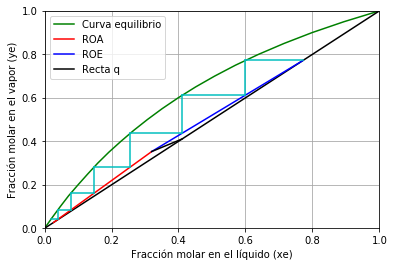

Pisos enriquecimiento  Pisos agotamiento  Pisos totales  \
Resultados                      3                  4              7   

            Pisos alimentación  
Resultados                   4

In [4]:
display(HTML('<h1 style="color:#000000"><strong>Finalmente, se dibujan las etapas de equilibrio.</strong></h1>'))


fig3=mpl.figure()

mpl.plot(xe,ye, 'g-',label = 'Curva equilibrio')
mpl.plot(ye,ye, 'k-')
mpl.xlabel('Fracción molar en el líquido (xe)')
mpl.ylabel('Fracción molar en el vapor (ye)')

mpl.grid(b=True, which='both', color='0.65',linestyle='-')
mpl.xlim(0,1)
mpl.ylim(0,1)


mpl.plot(xAgotamiento,yAgotamiento, 'r-',label = 'ROA')
mpl.plot(xEnriquecimiento,yEnriquecimiento, 'b-',label = 'ROE')
mpl.plot([xa,x_interseccion],[xa,y_interseccion],'k-',label = 'Recta q')



numeroEtapasEnriquecimiento=0
numeroEtapasAgotamiento=0
xDiagonal,yDiagonal=xd_a,xd_a #Valor inicial en la sección de enriquecimiento



while True:
    xequilibrio=optimize.fsolve(equilib,[0.5],args=(yDiagonal,alfa))  
    xequilibrio=float(xequilibrio)
    yequilibrio=yDiagonal
    mpl.plot([xDiagonal,xequilibrio],[yDiagonal,yequilibrio], 'c-')
    numeroEtapasEnriquecimiento+=1
    if xequilibrio>x_interseccion:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaEnriquecimiento(xDiagonal,Ln,D,xd_a)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
    else:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaAgotamiento(xDiagonal,Ln,D,xd_a,xa,caudalMolarA,q)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
        break

while True:
    xequilibrio=optimize.fsolve(equilib,[0.5],args=(yDiagonal,alfa))  
    xequilibrio=float(xequilibrio)
    yequilibrio=yDiagonal
    mpl.plot([xDiagonal,xequilibrio],[yDiagonal,yequilibrio], 'c-')
    numeroEtapasAgotamiento+=1
    if xequilibrio>=xr_a:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaAgotamiento(xDiagonal,Ln,D,xd_a,xa,caudalMolarA,q)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
    else:
        break
    
mpl.legend(loc = 'best')
mpl.show()

display(HTML('<h1 style="color:#000000"><strong>El número de etapas es:</strong></h1>'))


numeroPisosTeoricos=numeroEtapasEnriquecimiento+numeroEtapasAgotamiento
PisoAlimentacion=numeroEtapasEnriquecimiento+1


ResultadosNombres=['Pisos enriquecimiento','Pisos agotamiento',\
                   'Pisos totales','Pisos alimentación']
ResultadosValores=[numeroEtapasEnriquecimiento,numeroEtapasAgotamiento,numeroPisosTeoricos,PisoAlimentacion]

data3 = dict(zip(ResultadosNombres, ResultadosValores))
values3 = pd.DataFrame(data3,index=['Resultados'], columns=ResultadosNombres)
#values2.set_index('tiempo (min)',inplace=True)
display(values3)



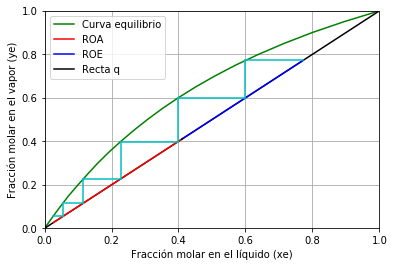

Pisos enriquecimiento  Pisos agotamiento  Pisos totales  \
Resultados                      2                  4              6   

            Pisos alimentación  
Resultados                   3

In [5]:
display(HTML('<h1 style="color:#000000"><strong>El número mínimo de etapas de equilibrio se determina\
    cuando las rectas de operación coinciden con la diagonal:</strong></h1>'))

RazonReflujo=1000

Ln=round(RazonReflujo*D,3)

fig4=mpl.figure()

mpl.plot(xe,ye, 'g-',label = 'Curva equilibrio')
mpl.plot(ye,ye, 'k-')
mpl.xlabel('Fracción molar en el líquido (xe)')
mpl.ylabel('Fracción molar en el vapor (ye)')

mpl.grid(b=True, which='both', color='0.65',linestyle='-')
mpl.xlim(0,1)
mpl.ylim(0,1)

x_interseccion=optimize.fsolve(InterseccionRO,[0.5],args=(Ln,D,xd_a,xa,A,q))

x_interseccion=round(float(x_interseccion),3)
y_interseccion=round(RectaOperativaEnriquecimiento(x_interseccion,Ln,D,xd_a),3)

xAgotamiento=[xr_a,x_interseccion]
yAgotamiento=[xr_a,y_interseccion]
mpl.plot(xAgotamiento,yAgotamiento, 'r-',label = 'ROA')

xEnriquecimiento=[x_interseccion,xd_a]
yEnriquecimiento=[y_interseccion,xd_a]
mpl.plot(xEnriquecimiento,yEnriquecimiento, 'b-',label = 'ROE')
mpl.plot([xa,x_interseccion],[xa,y_interseccion],'k-',label = 'Recta q')



numeroEtapasEnriquecimiento=0
numeroEtapasAgotamiento=0
xDiagonal,yDiagonal=xd_a,xd_a #Valor inicial en la sección de enriquecimiento



while True:
    xequilibrio=optimize.fsolve(equilib,[0.5],args=(yDiagonal,alfa))  
    xequilibrio=float(xequilibrio)
    yequilibrio=yDiagonal
    mpl.plot([xDiagonal,xequilibrio],[yDiagonal,yequilibrio], 'c-')
    numeroEtapasEnriquecimiento+=1
    if xequilibrio>x_interseccion:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaEnriquecimiento(xDiagonal,Ln,D,xd_a)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
    else:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaAgotamiento(xDiagonal,Ln,D,xd_a,xa,caudalMolarA,q)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
        break

while True:
    xequilibrio=optimize.fsolve(equilib,[0.5],args=(yDiagonal,alfa))  
    xequilibrio=float(xequilibrio)
    yequilibrio=yDiagonal
    mpl.plot([xDiagonal,xequilibrio],[yDiagonal,yequilibrio], 'c-')
    numeroEtapasAgotamiento+=1
    if xequilibrio>=xr_a:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaAgotamiento(xDiagonal,Ln,D,xd_a,xa,caudalMolarA,q)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
    else:
        break
    
mpl.legend(loc = 'best')
mpl.show()

display(HTML('<h1 style="color:#000000"><strong>El número de etapas es:</strong></h1>'))


numeroPisosTeoricos=numeroEtapasEnriquecimiento+numeroEtapasAgotamiento
PisoAlimentacion=numeroEtapasEnriquecimiento+1


ResultadosNombres=['Pisos enriquecimiento','Pisos agotamiento',\
                   'Pisos totales','Pisos alimentación']
ResultadosValores=[numeroEtapasEnriquecimiento,numeroEtapasAgotamiento,numeroPisosTeoricos,PisoAlimentacion]

data3 = dict(zip(ResultadosNombres, ResultadosValores))
values3 = pd.DataFrame(data3,index=['Resultados'], columns=ResultadosNombres)
#values2.set_index('tiempo (min)',inplace=True)
display(values3)




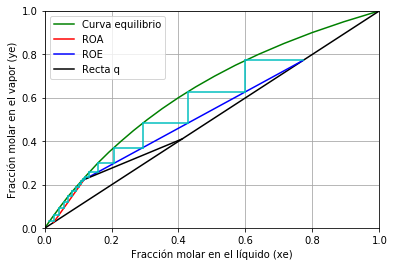

Razón de reflujo mínima  Pisos enriquecimiento  Pisos agotamiento  \
Resultados                     5.06                      8                  9   

            Pisos totales  Pisos alimentación  
Resultados             17                   9

In [6]:
display(HTML('<h1 style="color:#000000"><strong>El número máximo de etapas de equilibrio se determina\
   mediante el cálculo de la razón de reflujo mínima (102 % en este caso):</strong></h1>'))

RazonReflujo=RazonMinima*1.02

Ln=round(RazonReflujo*D,3)

fig5=mpl.figure()

mpl.plot(xe,ye, 'g-',label = 'Curva equilibrio')
mpl.plot(ye,ye, 'k-')
mpl.xlabel('Fracción molar en el líquido (xe)')
mpl.ylabel('Fracción molar en el vapor (ye)')

mpl.grid(b=True, which='both', color='0.65',linestyle='-')
mpl.xlim(0,1)
mpl.ylim(0,1)

x_interseccion=optimize.fsolve(InterseccionRO,[0.5],args=(Ln,D,xd_a,xa,A,q))

x_interseccion=round(float(x_interseccion),3)
y_interseccion=round(RectaOperativaEnriquecimiento(x_interseccion,Ln,D,xd_a),3)

xAgotamiento=[xr_a,x_interseccion]
yAgotamiento=[xr_a,y_interseccion]
mpl.plot(xAgotamiento,yAgotamiento, 'r-',label = 'ROA')

xEnriquecimiento=[x_interseccion,xd_a]
yEnriquecimiento=[y_interseccion,xd_a]
mpl.plot(xEnriquecimiento,yEnriquecimiento, 'b-',label = 'ROE')
mpl.plot([xa,x_interseccion],[xa,y_interseccion],'k-',label = 'Recta q')



numeroEtapasEnriquecimiento=0
numeroEtapasAgotamiento=0
xDiagonal,yDiagonal=xd_a,xd_a #Valor inicial en la sección de enriquecimiento



while True:
    xequilibrio=optimize.fsolve(equilib,[0.5],args=(yDiagonal,alfa))  
    xequilibrio=float(xequilibrio)
    yequilibrio=yDiagonal
    mpl.plot([xDiagonal,xequilibrio],[yDiagonal,yequilibrio], 'c-')
    numeroEtapasEnriquecimiento+=1
    if xequilibrio>x_interseccion:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaEnriquecimiento(xDiagonal,Ln,D,xd_a)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
    else:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaAgotamiento(xDiagonal,Ln,D,xd_a,xa,caudalMolarA,q)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
        break

while True:
    xequilibrio=optimize.fsolve(equilib,[0.5],args=(yDiagonal,alfa))  
    xequilibrio=float(xequilibrio)
    yequilibrio=yDiagonal
    mpl.plot([xDiagonal,xequilibrio],[yDiagonal,yequilibrio], 'c-')
    numeroEtapasAgotamiento+=1
    if xequilibrio>=xr_a:
        xDiagonal=xequilibrio
        yDiagonal=RectaOperativaAgotamiento(xDiagonal,Ln,D,xd_a,xa,caudalMolarA,q)
        mpl.plot([xequilibrio,xDiagonal],[yequilibrio,yDiagonal], 'c-')
    else:
        break
    
mpl.legend(loc = 'best')
mpl.show()

display(HTML('<h1 style="color:#000000"><strong>El número de etapas es:</strong></h1>'))


numeroPisosTeoricos=numeroEtapasEnriquecimiento+numeroEtapasAgotamiento
PisoAlimentacion=numeroEtapasEnriquecimiento+1


ResultadosNombres=['Razón de reflujo mínima','Pisos enriquecimiento','Pisos agotamiento',\
                   'Pisos totales','Pisos alimentación']
ResultadosValores=[round(RazonMinima,2),numeroEtapasEnriquecimiento,numeroEtapasAgotamiento,numeroPisosTeoricos,PisoAlimentacion]

data4 = dict(zip(ResultadosNombres, ResultadosValores))
values4 = pd.DataFrame(data4,index=['Resultados'], columns=ResultadosNombres)
#values2.set_index('tiempo (min)',inplace=True)
display(values4)

In [7]:
display(HTML('''

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Programado con Jupyter Notebook en Python 3.6. </footer>'''))